In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [3]:
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *


# Vanessa's implementations of $G^{ab}$s

### 1) $ G_l^{\phi\psi}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\psi}(\chi_1,\chi_2)$ 
$= \mathcal{A}^2 \frac{1}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} [1+z(\chi_2)] D(\chi_2) I^0_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{\nu_n-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

needs to be evaluated for varying $\chi_{max}$ and $\chi_2$ (this appears in Eq. 4.2).

replacing $\chi_2$ by $r\chi_{max}$ allows doing basically the same as before, just without summing over $r$,
so that the ouput for fixed $\chi_{max}$ has shape of $r$.
Then we only need one loop over $\chi_{max}$.

In [47]:
# agrees with parallelized code and agrees with Chirag's code
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chi1_max in enumerate((t_*chi_cmb)):
    if jj%10==0:
        print(jj)

    #psi goes with chi2
    chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
    chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

    # no lensing kernel, because no lensing integration of chi_2
    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*lensing_kernel(r2d*t2d*chi2_max, chi1_max))

    chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*lensing_kernel(r2d*1./t2d*chi2_max, chi1_max))

    chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs   = w12*chi1fac0* chi2fac0

    result = np.zeros((len(ell_),len(t_)))
    lmax   = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

    #jj is chi1 -> phi
    Cl[jj] = result*1./np.pi**2/2.*prefac**2 #divide by to for Gauss quad and times two for phi cancel
# swap axes to have cl_phipsi_l(chi_max,chi)
Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

# first axis ell, second phi, third psi
np.save('../G_matrices/clphipsi',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  163.23731112480164


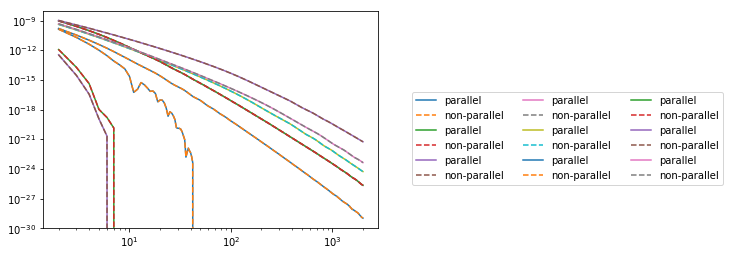

In [52]:
# comparing to parallel code
clphipsi_para=np.load('../G_matrices/clphipsi_parallel.npy')
clphipsi_para =np.swapaxes(clphipsi_para,0,1)
clphipsi_para.shape
for ii in [10,50,90]:
        for jj in [10,50,90]:
            plt.loglog(ell_,abs(clphipsi_para[:,ii,jj]),label='parallel')
            plt.loglog(ell_,abs(Cl[:,ii,jj]),ls='--',label='non-parallel')
plt.legend(ncol=3, loc=(1.1,0.2))

### tesing gaussian quadrature with simple integral test
$\int_0^1 \mathrm{d} x x^2 = 1/2 \sum_i w_i t_i^2 = 1/3 $

In [37]:
0.5*np.sum(w1*t_**2)

0.33333333387229197

## 2) $ G_l^{\phi\delta}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\delta}(\chi_1,\chi_2)$ 
$= \mathcal{A} \frac{2}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} D(\chi_2) I^2_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{(2+\nu_n)-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

In [38]:
#define different redshift kernels (at some point load this)

# 1) general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel


# 2) prospective LSST kernels
def dNdz_LSST(bin_num,dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'):
    if bin_num is "all":
        zbin, nbin = np.load(dn_filename+'tot_extrapolated.npy',encoding='latin1')
        norm                = np.trapz(nbin,zbin)
        mbin                = 'None'
    else:
        bins,big_grid,res   = np.load(dn_filename+'_extrapolated.npy',encoding='latin1')
        mbin                = bins[bin_num]
        zbin                = big_grid
        nbin                = res[bin_num]
        norm                = np.trapz(nbin,zbin)
    dndz                = interp1d(zbin, nbin/norm, kind='linear',bounds_error=False,fill_value=0.)
    print('using z-bin', mbin, 'norm', norm)
    return dndz



def gal_clus(dNdz,b,bin_num):
    """
    dNdz: function returning function dndz for gicen bin number 
    b: function returning bias as function of z 
    bin_num: bin_number (either 'all' or 0-5)
    """
    p_z=dNdz(bin_num)
    def kernel(x):
        z = z_chi(x)
        return b(z)*p_z(z)*dz_dchi(z)

    return kernel

def simple_bias(z):
    return (1.+z)

def constant_bias(z,b=1.):
    return b

In [31]:
# tested against chirags parallelized version
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


chimax2   = chi_cmb

n = 2

Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chimax1 in enumerate((t_*chi_cmb)):
    if jj%10==0:
        print(jj)
        
    chi1fac0  = D_chi(r2d*chimax2)
    chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))

    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*lensing_kernel(r2d*t2d*chi2_max, chimax1))
    
    chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs   = w12*chi1fac0* chi2fac0

    result    = np.zeros((len(ell_),len(t_)))
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))
    
    Cl[jj] = result*1./np.pi**2/2.*prefac/2.*2

Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)


# first axis ell, second phi, third delta
np.save('../G_matrices/clphidelta',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  157.4574203491211


### 4) $ G_l^{\psi\delta}(\chi_1, \chi_2) 
= \mathcal{A} \frac{1}{2\pi^2} D(\chi_2) D(\chi_1)  [1+z(\chi_1)] \sum_n \left[I^{(2)}_l (\nu_n,\chi_1/\chi_2)\chi_2^{-(\nu_n+2)} +I^{(2)}_l (\nu_n,\chi_2/\chi_1) \chi_1^{-(\nu_n+2)}\right]$

$= \mathcal{A} \frac{1}{2\pi^2} D(\chi_2) D(\chi_1)  [1+z(\chi_1)] \sum_n \left[2 I^{(2)}_l (\nu_n,\chi_1/\chi_2)\chi_2^{-(\nu_n+2)} \right] =\frac{\mathcal{A}}{2\pi^2} \sum_n [1+z(t\chi_2)] D(tr\chi_{cmb})D(r\chi_{cmb}) I^{(2)}_l (\nu_n,t) (r \chi_{cmb})^{-(\nu_n+n)}$

In [192]:


n  = 2 
Cl = np.zeros((len(ell_),len(t_),len(t_)))

# delta goes all the way to chi_cmb, psi is the dependent one
chi1fac0  = D_chi(r2d*chi_cmb)
chi1fac0  = chi1fac0 *(r2d*chi_cmb)**(-(n+nu_n_).reshape(1, 1, -1))
chi2fac0  = (D_chi(r2d*t2d*chi_cmb)*(1+z_chi(r2d*t2d*chi_cmb)))
    
chifacs   = chi2fac0 * chi1fac0

chifacs   = chi1fac0* chi2fac0


for ii  in range(ell_.size):        
    Cl[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(2))*1./np.pi**2/2.*prefac
    
    
np.save('../G_matrices/cldeltapsi',Cl)

cldeltapsi=Cl

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


In [304]:
from scipy.interpolate import interp2d
interp2d(r2d*chi_cmb,r2d*t2d*chi_cmb,cldeltapsi)

ValueError: Invalid length for input z for non rectangular grid

22.0


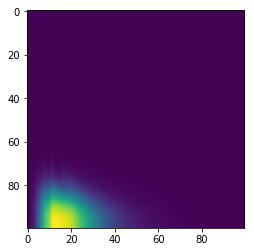

120.0


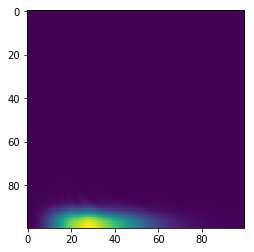

1920.0


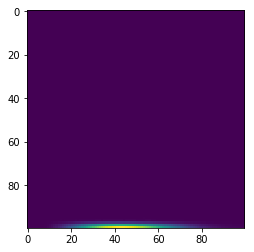

In [66]:
for ii in [20,100,280]:
    print(ell_[ii])
    plt.imshow(Cl[ii])
    plt.show()

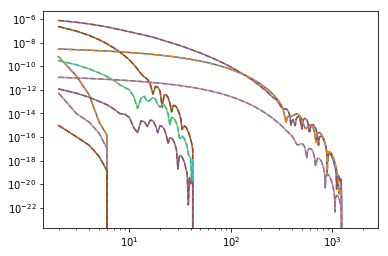

In [35]:
Clpsidelta2 = np.load('../output/cldeltapsi.npy')
for ii in [10,50,90]:
    for jj in [10,50,90]:
        plt.loglog(ell_, abs(Clpsidelta2[:,ii,jj]))
        plt.loglog(ell_, abs(cldeltapsi[:,jj,ii]),ls='--')

In [191]:
#computing Cldd in the same way we have computed cldeltapsi
r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

n  = 4
Cl = np.zeros((len(ell_),len(t_),len(t_)))

# delta goes all the way to chi_cmb, psi is the dependent one
chi1fac0  = D_chi(r2d*chi_cmb)
chi1fac0  = chi1fac0 *(r2d*chi_cmb)**(-(n+nu_n_).reshape(1, 1, -1))
chi2fac0  = D_chi(r2d*t2d*chi_cmb)
    
chifacs   = chi2fac0 * chi1fac0

chifacs   = chi1fac0* chi2fac0


for ii  in range(ell_.size):        
    Cl[ii] = np.sum(chifacs*I4_ltrc[ii],axis=(2))*1./np.pi**2/2.*prefac
    
    
np.save('../G_matrices/cldeltadelta',Cl)

cldeltadelta=Cl

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


(289, 100, 100)


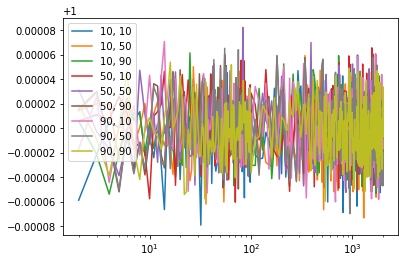

In [305]:
# comparing Chirags and mine Cl_phiphi(x1,x2)
clphiphi1 = np.load('../G_matrices/clphiphi_parallel.npy')
print(clphiphi1.shape)
clphiphi2 = np.load('../output/clphiphi.npy')
for ii in [10,50,90]:
    for jj in [10,50,90]:
        plt.semilogx(ell_,clphiphi1[:,ii,jj]/clphiphi2[:,ii,jj], label ='%d, %d'%(ii,jj))
plt.legend()
#--> they agree

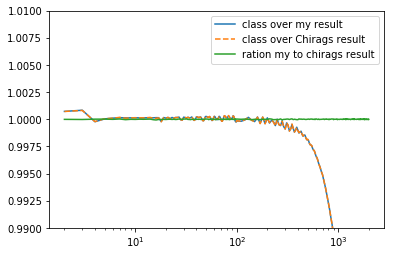

In [41]:
# and the x1=x2=x_cmb limit agrees with class
ll,clpp = np.load('../output/clpp_class_no_limber.npy')
plt.semilogx(ell_,np.interp(ell_,ll,clpp)/clphiphi1[:,99,99], label='class over my result')
plt.plot(ell_,np.interp(ell_,ll,clpp)/clphiphi2[:,99,99], ls='--', label='class over Chirags result')
plt.plot(ell_, clphiphi1[:,99,99]/clphiphi2[:,99,99], label='ration my to chirags result')
plt.ylim(0.99,1.01)
plt.legend()

In [43]:
ell_ext = np.linspace(max(ell_)+1,4000)
ell_ext = np.append(ell_,ell_ext)
clphiphi_Limber = np.interp(ell_ext,ll,clpp)
np.save('../G_matrices/clphiphi_noLimberCLASS',clphiphi_Limber)

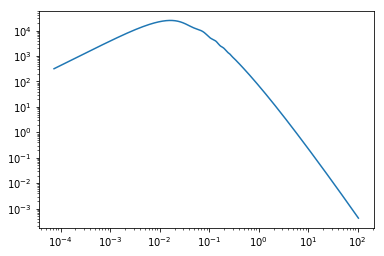

In [110]:
data = np.loadtxt('../pk_Planck2018BAO_matterpower_z000.dat')
k = data[:,0]
Pk = data[:,1]
plt.loglog(k,Pk)

In [111]:
Pk_ = interp1d(k,Pk,fill_value=0.,bounds_error=False)

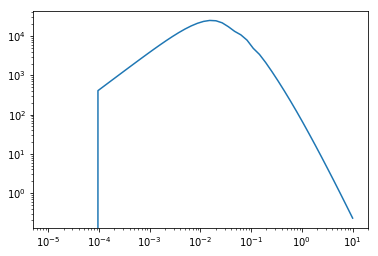

In [167]:
k_ = np.logspace(-5,1)
plt.loglog(k_,Pk_(k_))

In [300]:
r2d, t2d = np.meshgrid(t_,t_)

chigrid = r2d*chi_cmb
chigrid2= r2d*chi_cmb*t2d
print((chigrid[-1,:]-chigrid2[-1,:])/chigrid2[-1,:])

Cldeltapsi=np.zeros((len(ell_),len(t_),len(t_)))
for ii, ell in enumerate(ell_):
    k1 = ell/chigrid
    k2 = ell/chigrid2
    Cldeltapsi[ii] = D_chi(chigrid)*D_chi(chigrid2)*np.sqrt(Pk_(k1)*Pk_(k2))/k2**2*(1.+z_chi((chigrid2)))*prefac/chigrid

[0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.0001

In [301]:
chi = t_*chi_cmb

Cldeltapsi2=np.zeros((len(ell_),len(t_)))
for ii, ell in enumerate(ell_):
    k = ell/chi
    Cldeltapsi2[ii] = D_chi(chi)*D_chi(chi)*np.sqrt(Pk_(k)*Pk_(k))*(1.+z_chi((chi)))*prefac/ell

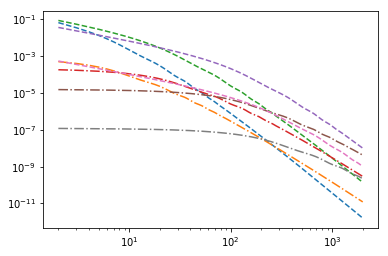

In [302]:
for jj in [10,20,50,90]:
    #plt.loglog(ell_, cldeltapsi[:,-1,jj])
    plt.loglog(ell_, Cldeltapsi[:,-1,jj],ls='--')
    plt.loglog(ell_, Cldeltapsi2[:,jj],ls='-.')

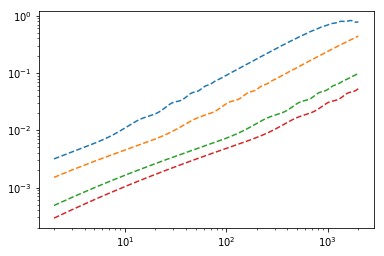

In [208]:
for jj in [10,20,50,90]:
    plt.loglog(ell_, cldeltapsi[:,-1,jj]/Cldeltapsi[:,-1,jj],ls='--')

In [243]:
# comparing Limber Cldd
r2d, t2d = np.meshgrid(t_,t_)

chigrid = r2d*chi_cmb
chigrid2= r2d*chi_cmb*t2d
print((chigrid[-1,:]-chigrid2[-1,:])/chigrid2[-1,:])

chis1 = chigrid[-1,:]
chis2 = chigrid2[-1,:]
Cldeltadelta=np.zeros((len(ell_),len(t_),len(t_)))
for ii, ell in enumerate(ell_):
    k1 = ell/chigrid
    k2 = ell/chigrid2
    Cldeltadelta[ii] = D_chi(chigrid)*D_chi(chigrid2)*np.sqrt(Pk_(k1)*Pk_(k2))/chigrid/chigrid2

[0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316
 0.00014316 0.00014316 0.00014316 0.00014316 0.00014316 0.0001

In [259]:
np.diff(t_)

array([0.00061089, 0.00109841, 0.0015851 , 0.00207027, 0.00255343,
       0.00303409, 0.00351179, 0.00398606, 0.00445644, 0.00492246,
       0.00538367, 0.00583962, 0.00628986, 0.00673396, 0.00717148,
       0.007602  , 0.00802508, 0.00844032, 0.00884732, 0.00924567,
       0.00963499, 0.0100149 , 0.01038501, 0.01074499, 0.01109446,
       0.01143309, 0.01176055, 0.01207652, 0.01238069, 0.01267277,
       0.01295246, 0.0132195 , 0.01347362, 0.01371457, 0.01394212,
       0.01415606, 0.01435615, 0.01454223, 0.01471409, 0.01487158,
       0.01501453, 0.01514282, 0.01525631, 0.01535489, 0.01543847,
       0.01550697, 0.01556031, 0.01559845, 0.01562135, 0.01562898,
       0.01562135, 0.01559845, 0.01556031, 0.01550697, 0.01543847,
       0.01535489, 0.01525631, 0.01514282, 0.01501453, 0.01487158,
       0.01471409, 0.01454223, 0.01435615, 0.01415606, 0.01394212,
       0.01371457, 0.01347362, 0.0132195 , 0.01295246, 0.01267277,
       0.01238069, 0.01207652, 0.01176055, 0.01143309, 0.01109

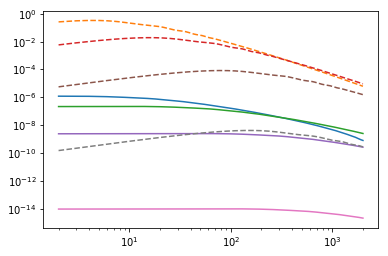

In [262]:
for jj in [10,20,50,90]:
    dchi = np.diff(chigrid2[-1])
    dchi = dchi[jj]
    dchi2 = np.diff(chigrid[-1])
    dchi2 = dchi2[jj]
    plt.loglog(ell_, cldeltadelta[:,-1,jj]*dchi)
    plt.loglog(ell_, Cldeltadelta[:,-1,jj],ls='--')

In [247]:
np.diff(chigrid2[-1])

array([  5.75044233,  10.33958908,  14.92093234,  19.48797832,
        24.03605021,  28.56065933,  33.05737137,  37.52178788,
        41.94954478,  46.3363145 ,  50.67781063,  54.96979061,
        59.20806076,  63.38847979,  67.50696322,  71.55948649,
        75.54209031,  79.45088313,  83.28204563,  87.03183463,
        90.69658649,  94.27271891,  97.75674078, 101.14524453,
       104.43492138, 107.62255671, 110.70503474, 113.67934606,
       116.54258196, 119.29194577, 121.92475189, 124.43842673,
       126.83051439, 129.09867849, 131.24070221, 133.25449298,
       135.13808156, 136.88962953, 138.50742463, 139.98988731,
       141.33556605, 142.54314958, 143.6114556 , 144.53944018,
       145.32619965, 145.97096118, 146.47309784, 146.83211733,
       147.04766946, 147.1195434 , 147.04766946, 146.83211733,
       146.47309784, 145.97096118, 145.32619965, 144.53944018,
       143.6114556 , 142.54314958, 141.33556605, 139.98988731,
       138.50742463, 136.88962953, 135.13808156, 133.25

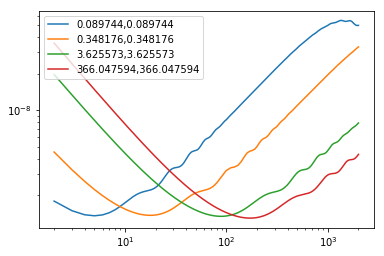

In [253]:
for jj in [10,20,50,90]:
    plt.loglog(ell_, cldeltadelta[:,-1,jj]/Cldeltadelta[:,-1,jj],label='%f,%f'%(z_chi(chigrid[-1,jj]),z_chi(chigrid[-1,jj])))
    plt.legend()

In [254]:
CL_diag = []
for ii in range(len(ell_)): 
    CL_diag+=[D_chi(t_*chi_cmb)*D_chi(t_*chi_cmb)*Pk_(ell_[ii]/(t_*chi_cmb))/(t_*chi_cmb)**2]
CL_diag=np.array(CL_diag)

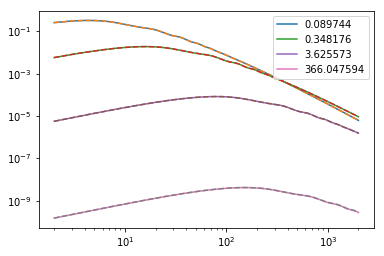

In [255]:
for jj in [10,20,50,90]:
    plt.loglog(ell_,CL_diag[:,jj],label='%f'%z_chi(t_[jj]*chi_cmb))
    plt.loglog(ell_,Cldeltadelta[:,-1,jj],ls='--')
plt.legend()

In [228]:
np.diff(chigrid[:,1])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [230]:
np.diff(chigrid2[:,1])

array([0.0043366 , 0.00779742, 0.01125236, 0.01469652, 0.01812637,
       0.02153852, 0.02492964, 0.0282964 , 0.03163552, 0.03494373,
       0.03821779, 0.04145451, 0.04465073, 0.04780332, 0.0509092 ,
       0.05396534, 0.05696875, 0.0599165 , 0.06280571, 0.06563355,
       0.06839725, 0.07109413, 0.07372155, 0.07627693, 0.07875778,
       0.08116168, 0.08348628, 0.0857293 , 0.08788856, 0.08996195,
       0.09194743, 0.09384308, 0.09564703, 0.09735753, 0.0989729 ,
       0.10049156, 0.10191204, 0.10323294, 0.10445297, 0.10557094,
       0.10658576, 0.10749644, 0.10830208, 0.10900191, 0.10959523,
       0.11008146, 0.11046014, 0.11073089, 0.11089344, 0.11094765,
       0.11089344, 0.11073089, 0.11046014, 0.11008146, 0.10959523,
       0.10900191, 0.10830208, 0.10749644, 0.10658576, 0.10557094,
       0.10445297, 0.10323294, 0.10191204, 0.10049156, 0.0989729 ,
       0.09735753, 0.09564703, 0.09384308, 0.09194743, 0.08996195,
       0.08788856, 0.0857293 , 0.08348628, 0.08116168, 0.07875